In [1]:
import subprocess
import tqdm
from pathlib import Path
import torch
import torch.nn as nn
import os
import numpy as np
from omegaconf import OmegaConf

import hydra
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig

import sys
sys.path.append('../')
from src.utils.protein import from_pdb_file, to_pdb
from src.models.TorsionalDiffusion import TDiffusionModule
from src.datamodules.components.helper import *
from src.models.components import get_atom14_coords
from src.utils.protein_analysis import ProteinAnalysis

from pyrosetta import init, pose_from_pdb, get_fa_scorefxn, Pose, standard_packer_task
import pickle
import glob

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
initialize(version_base="1.3", config_path="../configs")
# initialize(config_path="configs")
cfg = compose(config_name="eval_diffusion.yaml", return_hydra_config=True)
HydraConfig().cfg = cfg
OmegaConf.resolve(cfg)

In [3]:
molprobity_clash_loc = '/home/zhangjk/MolProbity/build/bin/molprobity.clashscore'
tmp_dir = '/home/zhangjk/test/PackPPI/temp2'
pdb_files = glob.glob('/home/zhangjk/test/PackPPI/data/casp14_set/*.pdb')
output_pkl = '/home/zhangjk/test/PackPPI/decoys_energy.pkl'
output_pdf = '/home/zhangjk/test/PackPPI/Figure3A1.pdf'
device = 'cuda:1' #"cpu"
decoys = 10

protein_analysis = ProteinAnalysis(molprobity_clash_loc, tmp_dir)

In [4]:
model = TDiffusionModule.load_from_checkpoint(
    # allow one to evaluate with an older model using custom hyperparameters
    checkpoint_path=cfg.ckpt_path,
    map_location=device,
    strict=False,
    encoder_cfg=hydra.utils.instantiate(cfg.model.encoder_cfg),
    model_cfg=hydra.utils.instantiate(cfg.model.model_cfg),
    sample_cfg=hydra.utils.instantiate(cfg.model.sample_cfg)
)

model = model.to(device)
model.eval()


TDiffusionModule(
  (encoder): ProteinEncoder(
    (timestep_emb_func): SinusoidalEmbedding()
    (node_embedding): Linear(in_features=51, out_features=128, bias=True)
    (norm_nodes): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (edge_embedding): Linear(in_features=468, out_features=128, bias=True)
    (norm_edges): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (embeddings): PositionalEncodings()
  )
  (mpnn): MpnnNet(
    (mpnn_layers): ModuleList(
      (0-2): 3 x InvariantPointMessagePassing(
        (points_fn_node): Linear(in_features=128, out_features=24, bias=True)
        (points_fn_edge): Linear(in_features=128, out_features=24, bias=True)
        (node_message_fn): MLP(
          (W_in): Linear(in_features=456, out_features=128, bias=True)
          (W_inter): ModuleList(
            (0): Linear(in_features=128, out_features=128, bias=True)
          )
          (W_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_me

In [5]:
def analyze_proteins(pdb_files, output_pkl, decoys, model, device):
    init('-mute all '
         '-ex1 -ex2 -ex3 -ex4 '
         '-ignore_unrecognized_res '
         '-ignore_zero_occupancy false '
         '-load_PDB_components false ' 
         '-relax:default_repeats 2 '
         '-no_fconfig ')
    
    scorefxn = get_fa_scorefxn()
    data = {}

    for i in tqdm.trange(len(pdb_files)):
        in_pdb = pdb_files[i]
        protein = vars(from_pdb_file(Path(in_pdb), mse_to_met=True))
        batch = protein_analysis.get_prot(in_pdb)
        batch = batch.to(device)
    
        sample_iter = []
        resample_iter = []
    
        try:
            pose = pose_from_pdb(in_pdb)
            true_score = scorefxn(pose)
        except RuntimeError as e:
            continue
            
        for num in range(0, decoys):
            try:
                SC_D_sample, SC_D_resample_list, _  = model.sampling(batch, use_proximal=True, return_list=True)
            except RuntimeError as e:
                torch.cuda.empty_cache()
                break
    
            predict_xyz = get_atom14_coords(batch.X, batch.residue_type, batch.BB_D, SC_D_sample)
            protein['atom_positions'] = predict_xyz.cpu().squeeze().numpy()
            temp_protein = to_pdb(protein)
             
            with open(protein_analysis.tmp_pdb, 'w') as temp_file:
                temp_file.writelines(temp_protein)
    
            try:
                pose = pose_from_pdb(protein_analysis.tmp_pdb)
                score = scorefxn(pose)
            except RuntimeError as e:
                break
            sample_iter.append(score)
    
    
            predict_xyz = get_atom14_coords(batch.X, batch.residue_type, batch.BB_D, SC_D_resample_list[-1])
            protein['atom_positions'] = predict_xyz.cpu().squeeze().numpy()
            temp_protein = to_pdb(protein)
             
            with open(protein_analysis.tmp_pdb, 'w') as temp_file:
                temp_file.writelines(temp_protein)
    
            try:
                pose = pose_from_pdb(protein_analysis.tmp_pdb)
                score = scorefxn(pose)
            except RuntimeError as e:
                break
            resample_iter.append(score)
    
        data[f'sample_{i}_true'] = true_score
        data[f'sample_{i}_packppi'] = sample_iter
        data[f'sample_{i}_packppi_Prox'] = resample_iter
            
        if i==0:
            print(data)

    with open(output_pkl, 'wb') as f:
        pickle.dump(data, f)


def process_and_plot(data, output_pdf):
    """
    Process the data to remove empty samples and plot the results.
    
    Parameters:
    data (dict): A dictionary containing sample data.
    """
    # Identify samples to remove
    samples_to_remove = []
    for i in range(0, 4):  # Adjust based on the actual number of samples
        packppi_key = f'sample_{i}_packppi'
        packppi_prox_key = f'sample_{i}_packppi_Prox'
        true_key = f'sample_{i}_true'

        # Check if both packppi and packppi_Prox are empty
        if data.get(packppi_key) == [] and data.get(packppi_prox_key) == []:
            samples_to_remove.append(true_key)
            samples_to_remove.append(packppi_key)
            samples_to_remove.append(packppi_prox_key)

    # Remove empty sample data
    for key in samples_to_remove:
        data.pop(key, None)

    # Calculate the number of remaining samples based on the true keys
    remaining_samples = [key for key in data.keys() if key.endswith('_true')]
    num_samples = len(remaining_samples)

    # Sort samples based on the value of sample_i_true
    sorted_samples = sorted([(data[key], int(key.split('_')[1])) for key in remaining_samples], key=lambda x: x[0])

    # Prepare x and y values for plotting
    y_true_sorted = [true_value for true_value, _ in sorted_samples]  # Sorted true values
    x_indices = [i + 1 for i in range(len(y_true_sorted))]  # X-axis labels as sample indices

    # Calculate mean and standard deviation
    mean_value = np.mean(y_true_sorted)
    std_dev = np.std(y_true_sorted)

    # Remove points that are more than two standard deviations away
    filtered_indices = [i for i, y in enumerate(y_true_sorted) if abs(y - mean_value) <= 2 * std_dev]
    filtered_x = [x_indices[i] for i in filtered_indices]
    filtered_y = [y_true_sorted[i] for i in filtered_indices]
    filtered_samples = [sorted_samples[i] for i in filtered_indices]

    # Initialize the plot
    plt.figure(figsize=(8, 5))

    # Check if legend exists
    handles, labels = plt.gca().get_legend_handles_labels()

    # Plot packppi and packppi_Prox values
    for true_value, sample_index in filtered_samples:
        x_value = filtered_x[filtered_samples.index((true_value, sample_index))]
        
        if f'sample_{sample_index}_packppi' in data:
            packppi_values = data[f'sample_{sample_index}_packppi']
            plt.scatter([x_value] * len(packppi_values), packppi_values, color='#FF9999', alpha=0.7, s=15, 
                        label='packppi' if 'packppi' not in labels else "")
            handles, labels = plt.gca().get_legend_handles_labels()  # Update legend information

        if f'sample_{sample_index}_packppi_Prox' in data:
            packppi_Prox_values = data[f'sample_{sample_index}_packppi_Prox']
            plt.scatter([x_value] * len(packppi_Prox_values), packppi_Prox_values, color='#7F7FFF', alpha=0.7, s=15, 
                        label='packppi_Prox' if 'packppi_Prox' not in labels else "")
            handles, labels = plt.gca().get_legend_handles_labels()  # Update legend information

    # Plot true values scatter (on top)
    plt.scatter(filtered_x, filtered_y, color='purple', label='true (PyRosetta)', marker='o', alpha=0.7, s=15)

    # Add labels and legend
    plt.xlabel('Sample index (ordered by true value)')
    plt.ylabel('Values')
    plt.title('Values of true, packppi, and packppi_Prox')
    plt.legend()

    plt.savefig(output_pdf, format='pdf')
    plt.show()

In [6]:
analyze_proteins(pdb_files, output_pkl, decoys, model, device)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.ubuntu 2024.19+release.a34b73c40fe9c61558d566d6a63f803cfb15a4fc 2024-05-02T16:22:03] retrieved from: http://www.pyrosetta.org


  3%|██                                                                  | 1/34 [00:34<19:01, 34.58s/it]

{'sample_0_true': 43.54314892145872, 'sample_0_packppi': [610.5937818676106, 1350.5830107433155, 1173.9639716537838, 1011.352674050657, 999.3844415114406, 996.2332649752734, 1020.9490852574386, 733.5810775463367, 1226.2525406671227, 856.3143970038441], 'sample_0_packppi_Prox': [-44.281298400532435, 235.2466375873783, 120.15350835840614, -21.534184467315256, 152.70920781922905, 52.650781944320315, 66.59830403990951, 19.247226742017844, 126.35265544547524, 66.95943032589865]}


100%|███████████████████████████████████████████████████████████████████| 34/34 [17:31<00:00, 30.93s/it]


In [8]:
with open(output_pkl, 'rb') as f:
    data = pickle.load(f)

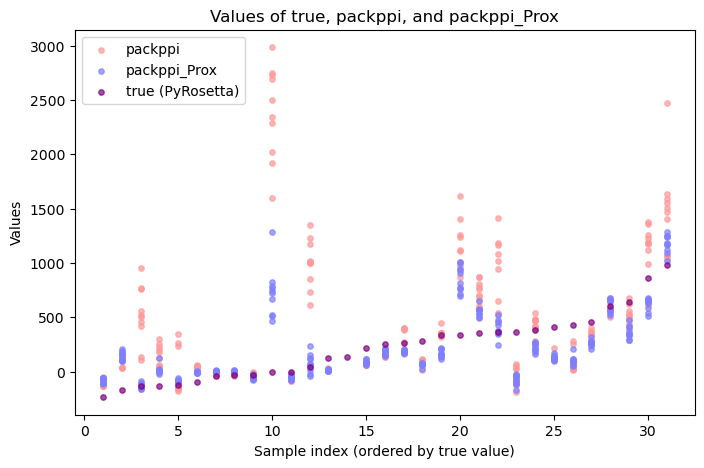

In [9]:
process_and_plot(data, output_pdf)